In [6]:
from sklearn.preprocessing import MinMaxScaler
from tsfresh import select_features
from tsfresh.feature_extraction import extract_features
import keras
from tensorflow.keras import layers
from tensorflow import keras
import pandas as pd
import sys
sys.path.append('..')
from lib.download import *
from indicators.indicators import get_pair_tickers

usdt_tickers = get_pair_tickers()
data = pd.read_pickle(f'data/usdt_data_features/{usdt_tickers[3]}.pickle').astype(float)
data = data.dropna()
data = (data - data.mean()) / data.std()
data = data.T.dropna().T
train_data = data.iloc[:int(data.shape[0] * 0.8), :]
test_data = data.iloc[int(data.shape[0] * 0.8):, :]

FileNotFoundError: [WinError 3] Le chemin d’accès spécifié est introuvable: 'data/usdt_data_features'

In [3]:
from lib.download import update_data_features
update_data_features(symbols=get_symbol())

FileNotFoundError: [WinError 3] Le chemin d’accès spécifié est introuvable: 'data/usdt_data_features'

In [106]:
def sampling(args):
    z_mean, z_log_var = args
    batch = keras.backend.shape(z_mean)[0]
    dim = keras.backend.int_shape(z_mean)[1]
    epsilon = keras.backend.random_normal(shape=(batch, dim))
    return z_mean + keras.backend.exp(0.5 * z_log_var) * epsilon

def train_vae(latent_dim, train_data, test_data):
    encoder_inputs = keras.Input(shape=(train_data.shape[1],))
    x = layers.Dense(256, activation="relu")(encoder_inputs)
    x = layers.Dense(128, activation="relu")(x)
    x = layers.Dense(64, activation="relu")(x)
    z_mean = layers.Dense(latent_dim)(x)
    z_log_var = layers.Dense(latent_dim)(x)

    encoder = keras.Model(encoder_inputs, [z_mean, z_log_var], name="encoder")

    latent_inputs = keras.Input(shape=(latent_dim,))
    x = layers.Dense(64, activation="relu")(latent_inputs)
    x = layers.Dense(128, activation="relu")(x)
    x = layers.Dense(256, activation="relu")(x)
    decoder_outputs = layers.Dense(train_data.shape[1])(x)

    decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")

    encoder_outputs = encoder(encoder_inputs)
    latent_outputs = encoder_outputs[0]
    latent_outputs = keras.layers.Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])
    decoder_outputs = decoder(latent_outputs)

    vae = keras.Model(encoder_inputs, decoder_outputs, name="vae")

    vae.compile(optimizer="adam", loss="mse")
    history = vae.fit(train_data, train_data, epochs=100, batch_size=64, validation_data=(test_data, test_data))#, verbose=0)
    last_10_epochs_loss = history.history['val_loss'][-10:]
    mean_loss = np.mean(last_10_epochs_loss)
    return mean_loss, encoder, history

In [3]:
import numpy as np
latent_dims=[x*3 for x in range(5,20)]
losss=[]
for latent_dim in tqdm(latent_dims):
    mean_loss, encoder, history = train_vae(latent_dim, train_data, test_data)
    losss.append([mean_loss, latent_dim])

100%|██████████| 15/15 [29:23<00:00, 117.56s/it]


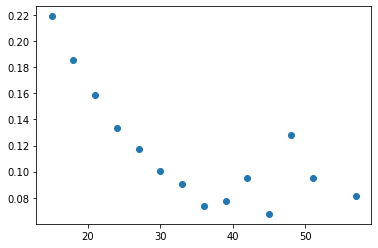

In [11]:
import matplotlib.pyplot as plt
plt.scatter(np.array(losss).T[1], np.array(losss).T[0])

In [18]:
3*np.argmin(np.array(losss).T[0])

39

In [107]:
mean_loss, encore, history = train_vae(39, train_data, test_data)

Epoch 1/100
449/449 [==============================] - 2s 4ms/step - loss: 0.4645 - val_loss: 0.3316
Epoch 2/100
449/449 [==============================] - 1s 3ms/step - loss: 0.3055 - val_loss: 0.2733
Epoch 3/100
449/449 [==============================] - 1s 3ms/step - loss: 0.2650 - val_loss: 0.2485
Epoch 4/100
449/449 [==============================] - 1s 3ms/step - loss: 0.2195 - val_loss: 0.2182
Epoch 5/100
449/449 [==============================] - 1s 3ms/step - loss: 0.2020 - val_loss: 0.2842
Epoch 6/100
449/449 [==============================] - 1s 3ms/step - loss: 0.2396 - val_loss: 0.2092
Epoch 7/100
449/449 [==============================] - 1s 3ms/step - loss: 0.2056 - val_loss: 0.3998
Epoch 8/100
449/449 [==============================] - 1s 3ms/step - loss: 0.2393 - val_loss: 0.2478
Epoch 9/100
449/449 [==============================] - 1s 3ms/step - loss: 0.2133 - val_loss: 0.1907
Epoch 10/100
449/449 [==============================] - 1s 3ms/step - loss: 0.1606 - val_lo

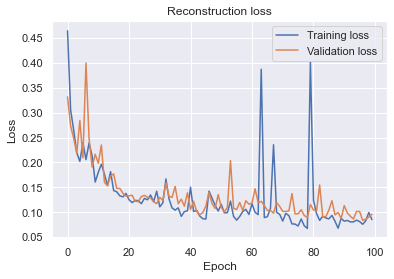

In [108]:
import matplotlib.pyplot as plt
# Plot the reconstruction loss
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.title('Reconstruction loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [109]:
features_train = encore.predict(train_data)
features_test = encore.predict(test_data)
features = pd.concat([pd.DataFrame(features_train[0]), pd.DataFrame(features_test[0])],axis=0, ignore_index=True)
features.index = data.index
features.tail()

225/225 [==============================] - 0s 1ms/step


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38
timestamp,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2023-01-24 12:00:00,2.708541,3.833568,-3.889508,1.800808,0.675807,-0.439657,-0.766331,-0.488751,-4.944818,1.139741,7.762022,-0.332758,0.519605,1.118217,-2.784148,0.086705,-1.481560,-0.430333,1.055209,2.588193,0.774061,-0.206047,1.741665,-2.203450,-1.250325,0.468438,0.754649,0.061385,0.519228,-2.547283,1.403308,3.716915,-2.720252,-1.095918,-0.874499,-0.781940,-0.217129,-0.901891,-0.333552
2023-01-24 13:00:00,0.186071,2.089528,-2.717747,0.075429,0.122526,-0.957965,-0.481479,-0.110981,-6.154900,-0.449733,6.918820,0.730072,-0.609825,2.698234,-1.131761,1.584318,-0.504007,0.066250,1.124848,3.340880,0.226376,-0.019041,2.902889,-4.473303,-0.290358,0.934691,-0.020269,-0.618538,1.845581,-2.974583,0.691941,3.162427,-2.967301,1.134480,-1.177518,-0.033253,0.650506,-1.182144,-1.771460
2023-01-24 14:00:00,0.155231,1.289127,-2.972730,-0.275213,-0.443365,-0.849225,-0.617579,1.239641,-5.966458,-1.336563,8.344582,1.991305,-0.680005,1.501010,0.597325,2.332831,0.103002,0.043816,0.750761,3.938478,0.303744,0.516370,2.960310,-3.269495,0.926992,0.688233,-0.015962,-0.288110,2.132209,-1.728345,1.274279,2.661451,-3.649600,1.312841,-0.520428,0.618972,0.736343,-0.641797,-2.758691
2023-01-24 15:00:00,1.713950,2.651748,-4.695969,0.402887,1.686676,-2.778129,-1.482696,0.828004,-3.490202,-1.386660,10.883994,1.314728,-1.754210,-0.315885,-0.385359,0.934939,0.515663,-1.769475,-1.044403,2.414151,1.040259,-0.719236,3.448647,-0.799038,0.705680,0.028094,1.551540,-0.956146,1.196871,-2.344818,2.151270,3.267490,-3.453157,-0.542329,0.549315,-2.966976,0.482486,-0.833461,-0.976778
2023-01-24 16:00:00,2.014184,2.119113,-4.197031,0.160693,-1.828065,0.453111,0.118212,0.698689,-4.928053,-0.595569,10.397546,0.910546,-0.295591,1.956903,-0.161378,1.342060,-0.555552,-0.738270,3.188819,3.181230,1.084576,1.208201,1.795102,-4.207245,0.867884,-0.138422,-1.151515,-0.778062,2.730960,-1.292763,0.137769,3.005934,-3.052011,1.116137,-0.836890,-0.354250,0.600761,0.072115,-1.379932


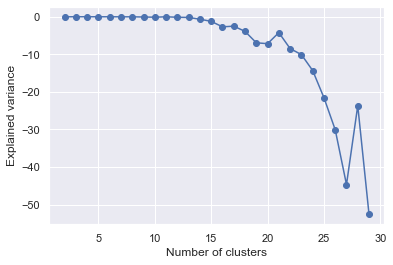

In [110]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import explained_variance_score

scaler = StandardScaler()

data_returns = data['close'].pct_change().dropna()
returns_data_scaled = scaler.fit_transform(np.array(data_returns).reshape(-1,1))

explained_variance = []
for i in range(2, 30):
    kmeans = KMeans(n_clusters=i, random_state=0)
    kmeans.fit(returns_data_scaled)
    explained_variance.append(explained_variance_score(returns_data_scaled, kmeans.predict(returns_data_scaled)))
  
plt.plot(range(2, 30), explained_variance, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Explained variance')
plt.show()

In [111]:
explained_variance

[-0.00890139906044074,
 0.002146873366157487,
 0.00673663045761963,
 -0.0027124166285936724,
 -0.003349233126804796,
 -0.015656736929329007,
 -0.015070594964043504,
 -0.06608963543784085,
 -0.1153895122294013,
 -0.010923749760396673,
 -0.13088646937733328,
 -0.18392307577971923,
 -0.6489863366069251,
 -1.2279029061048665,
 -2.679878866315438,
 -2.5020876591862233,
 -3.888663626282187,
 -6.930225343658043,
 -7.166967123777072,
 -4.2203353017515575,
 -8.472475070718136,
 -10.067951690091673,
 -14.312335951990073,
 -21.545286998411083,
 -30.074808551631243,
 -44.671928094402304,
 -23.674271582494757,
 -52.62630025058217]

In [ ]:
polynomial + isolation cluster du au fait que je n'ai pas winsor les xcas extremes

In [73]:
kmeans = KMeans(n_clusters=21, random_state=0)
clusters = kmeans.fit_predict(returns_data_scaled)
pd.DataFrame(clusters).value_counts()

0     34954
12      437
14      290
18       62
11       40
8        21
20       15
6         4
15        4
5         3
10        3
4         2
19        2
7         1
9         1
1         1
13        1
3         1
16        1
17        1
2         1
dtype: int64

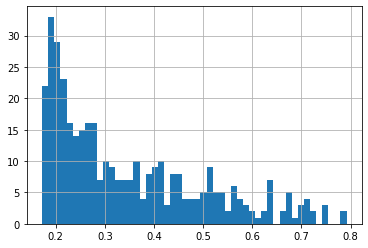

In [61]:
class_ret_df = pd.concat([data_returns,pd.DataFrame(clusters, index=data_returns.index, columns=['class'])],axis=1)
class_ret_df['prix'] = data['close'][data.index.isin(class_ret_df.index)]

for i in range(8):
    print(class_ret_df['close'][class_ret_df['class']==i].mean()*100)
    
class_ret_df['close'][class_ret_df['class']==7].hist(bins=50);

In [86]:
new_features = features.iloc[1:,:]
new_features["class"] = clusters

In [102]:
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(new_features.iloc[:,:1], new_features["class"], test_size = 0.2)

scaler = StandardScaler()
lgbm = LGBMClassifier(class_weight='balanced')

train_scaledd = scaler.fit_transform(X_train)
test_scaledd = scaler.transform(X_test)

lgbm.fit(train_scaledd, y_train)

predictions = lgbm.predict(test_scaledd)
predictions = pd.DataFrame(predictions)

accuracy_score on test dataset : 0.23824801227507322
              precision    recall  f1-score   support

           0       0.24      0.99      0.39      1702
           1       0.00      0.00      0.00        31
           2       0.00      0.00      0.00        25
           3       0.00      0.00      0.00        23
           4       0.00      0.00      0.00        39
           5       0.00      0.00      0.00        24
           6       0.00      0.00      0.00       110
           7       0.00      0.00      0.00        39
           8       0.00      0.00      0.00       388
           9       0.00      0.00      0.00        27
          10       0.00      0.00      0.00        47
          11       0.00      0.00      0.00       481
          12       0.19      0.01      0.03      1114
          13       0.00      0.00      0.00         0
          14       0.25      0.01      0.02      1809
          15       0.00      0.00      0.00        91
          16       0.00     

<AxesSubplot: >

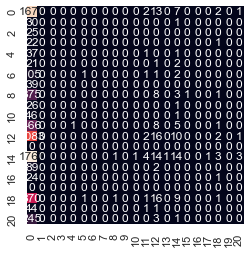

In [103]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
accuracy_test = accuracy_score(y_test, predictions)
print('accuracy_score on test dataset :', accuracy_test)
print(classification_report(predictions, y_test))
sns.set()
mat=confusion_matrix(y_test, predictions)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)

In [93]:
predictions.value_counts()

0     6095
12     281
18     205
11     200
17     142
19     113
1       43
5       35
20      28
15      27
dtype: int64

In [23]:
close_features = extract_features(test[["index", "Close"]], column_id='index')

Feature Extraction: 100%|██████████| 30/30 [00:13<00:00,  2.24it/s]


In [49]:
indexed_data = data.copy()
indexed_data['id'] = pd.Series(range(len(indexed_data)), index=data.index)

In [50]:
indexed_data = indexed_data.reset_index().iloc[:,1:].reset_index()

In [75]:
close_relevant_features = select_features(nanless_close_features.reset_index().iloc[1:,1:], indexed_data['Close'].diff().iloc[1:])

In [67]:
nanless_close_features = close_features.T.dropna().T.copy()

#au lieu de faire le dropna() faire du back fill et drop ceux avec trop de d onnées manquantes

In [ ]:
https://www.kaggle.com/code/patrickurbanke/feature-engineering-for-time-series

In [ ]:
polynomial elbow + kmeans test train
#differencier 1, 2, 3 fois
#n x n features